Basic imports

In [13]:
import time
import random
import numpy as np

from scipy.stats import ortho_group

import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn.functional as F
from torch.nn import Linear, ReLU, BatchNorm1d, Module, Sequential

import torch_geometric
from torch_geometric.data import Data
from torch_geometric.data import Batch
from torch_geometric.datasets import QM9
import torch_geometric.transforms as T
from torch_geometric.utils import remove_self_loops, to_dense_adj, dense_to_sparse
from torch_geometric.loader import DataLoader
from torch_geometric.nn import MessagePassing, global_mean_pool
from torch_geometric.datasets import QM9
from torch_scatter import scatter

import networkx as nx

In [2]:
print("PyTorch version {}".format(torch.__version__))
print("PyG version {}".format(torch_geometric.__version__))

PyTorch version 2.2.0+cu118
PyG version 2.6.1


In [3]:
#@title [RUN] Set random seed for deterministic results

def seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed(0)

Functions - may not need

In [4]:
# For storing experimental results over the course of the practical
RESULTS = {}
DF_RESULTS = pd.DataFrame(columns=["Train MSE", "Test MSE", "Val MSE", "Epoch", "Model"])

In [5]:
import helper
train_data = helper.load_data_from_file("../../data/graph_data_duplicates_v2.json") # dictionary of SMILES and values are graphs

In [10]:
pdtable = pd.read_csv("../../data/periodictable.csv", usecols=[0, 2])
atom_dict = dict(zip(pdtable['Symbol'], pdtable['AtomicNumber'])) 

In [11]:
orb_dict = {
 '1s': [1, 0, 0],
 '2s': [2, 0, 0],
 '2p': [2, 1, 0],
 '2p3/2': [2, 1, 1.5],
    
 '3s': [3, 0, 0],
 '3p': [3, 1, 0],
 '3p3/2': [3, 1, 1.5],
 '3d': [3, 2, 0],
 '3d5/2': [3, 2, 2.5],
    
 '4s': [4, 0, 0],
 '4p3/2': [4, 1, 1.5],
 '4d': [4, 2, 0],
 '4d5/2': [4, 2, 2.5],
 '4f7/2': [4, 3, 3.5],
    
 '5s': [5, 0, 0],
 '5p3/2': [5, 1, 1.5],
 '5d5/2': [5, 2, 2.5],
}

orb_list = list(orb_dict.keys())

bond_dict = {'SINGLE':1, 'DOUBLE':2, 'TRIPLE':3, 'NONE':0}

In [12]:
import pandas as pd
iso_be_df = pd.read_csv('../Isolated_Energy_final.csv')

In [14]:
dataset = []

for i, mol in enumerate(train_data):
    graph = train_data[mol]
    
    # Node info
    atom = list(nx.get_node_attributes(graph, "atom_type").values())
    charge = list(nx.get_node_attributes(graph, "formal_charge").values())
    orb = list(nx.get_node_attributes(graph, "orbitals").values())
    energy = list(nx.get_node_attributes(graph, "binding_energies").values())
    targets = list(nx.get_node_attributes(graph, "target").values())
    atom_index = targets.index(True)
    
    # Prepare dataset for this graph
    
    # Node feature shape (# atoms by target, atomic number, charge, one-hot encoding for orbital)
    x = np.zeros((len(atom), 20))
    # One global property for graph
    y = np.zeros(len(atom))
    
    x[:, 1] = [atom_dict[a] for a in atom]  # Indicate atomic numbers
    x[:, 2] = charge
    x[atom_index, 0] = 1  # Indicate target atom
    
    # One hot-encode orbital, double check
    x[atom_index, 3 + orb_list.index(orb[atom_index][0])] = 1 
        
    # Encode edge indices
    bond_types = list(nx.get_edge_attributes(graph, "bond_type").values())
    
    # Fix for edge_attr construction
    edge_attr = torch.tensor([bond_dict[b] for b in bond_types], dtype=torch.float)
    edge_attr = edge_attr.unsqueeze(1)
    
    # Fix for edge_index construction
    edge_index = torch.tensor(list(graph.edges), dtype=torch.long).t().contiguous()
    
    # Make PyG friendly
    x = torch.tensor(x, dtype=torch.float)
    edge_index = torch.tensor(edge_index, dtype=torch.long)
    edge_attr = torch.tensor(edge_attr, dtype=torch.float)
    y = torch.tensor([energy[atom_index][0]], dtype=torch.float)

    # Isolated binding energy
    be = float(iso_be_df.loc[atom_dict[atom[atom_index]]-1,orb[atom_index][0]]) 
    
    # Then proceed with creating the Data object
    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y-be, name=mol, y0=be)
    dataset.append(data)

/home/shrihan/ipykernel_2095202/4199736423.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edge_index, dtype=torch.long)
/home/shrihan/ipykernel_2095202/4199736423.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_attr = torch.tensor(edge_attr, dtype=torch.float)


Data prep and splitting

In [15]:
print(f"Total number of samples: {len(dataset)}.")

# Split datasets (our 3K subset)
train_dataset = dataset[:3000]
val_dataset = dataset[3000:4000]
test_dataset = dataset[4000:]
print(f"Created dataset splits with {len(train_dataset)} training, {len(val_dataset)} validation, {len(test_dataset)} test samples.")

# Create dataloaders with batch size = 32
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Total number of samples: 5192.
Created dataset splits with 3000 training, 1000 validation, 1192 test samples.


### Blueprint of data objects

**Atom features (`data.x`)** - $\mathbb{R}^{|V| \times 11}$
- 1st-5th features: Atom type (one-hot: H, C, N, O, F)
- 6th feature (also `data.z`): Atomic number (number of protons).
- 7th feature: Aromatic (binary)
- 8th-10th features: Electron orbital hybridization (one-hot: sp, sp2, sp3)
- 11th feature: Number of hydrogens

**Edge Index (`data.edge_index`)** - $\mathbb{R}^{2×|E|}$
- A tensor of dimensions 2 x `num_edges` that describe the edge connectivity of the graph

**Edge features (`data.edge_attr`)** - $\mathbb{R}^{|E|\times 4}$
- 1st-4th features: bond type (one-hot: single, double, triple, aromatic)

**Target (`data.y`)** - $\mathbb{R}^{1}$
- A scalar value corresponding to the target electron's binding energy

In [16]:
class MPNNLayer(MessagePassing):
    def __init__(self, emb_dim=64, edge_dim=1, aggr='add'):
        """Message Passing Neural Network Layer

        Args:
            emb_dim: (int) - hidden dimension `d`
            edge_dim: (int) - edge feature dimension `d_e`
            aggr: (str) - aggregation function `\oplus` (sum/mean/max)
        """
        # Set the aggregation function
        super().__init__(aggr=aggr)

        self.emb_dim = emb_dim
        self.edge_dim = edge_dim

        # MLP `\psi` for computing messages `m_ij`
        # Implemented as a stack of Linear->BN->ReLU->Linear->BN->ReLU
        # dims: (2d + d_e) -> d
        self.mlp_msg = Sequential(
            Linear(2*emb_dim + edge_dim, emb_dim), BatchNorm1d(emb_dim), ReLU(),
            Linear(emb_dim, emb_dim), BatchNorm1d(emb_dim), ReLU()
          )

        # MLP `\phi` for computing updated node features `h_i^{l+1}`
        # Implemented as a stack of Linear->BN->ReLU->Linear->BN->ReLU
        # dims: 2d -> d
        self.mlp_upd = Sequential(
            Linear(2*emb_dim, emb_dim), BatchNorm1d(emb_dim), ReLU(),
            Linear(emb_dim, emb_dim), BatchNorm1d(emb_dim), ReLU()
          )

    def forward(self, h, edge_index, edge_attr):
        """
        The forward pass updates node features `h` via one round of message passing.

        As our MPNNLayer class inherits from the PyG MessagePassing parent class,
        we simply need to call the `propagate()` function which starts the
        message passing procedure: `message()` -> `aggregate()` -> `update()`.

        The MessagePassing class handles most of the logic for the implementation.
        To build custom GNNs, we only need to define our own `message()`,
        `aggregate()`, and `update()` functions (defined subsequently).

        Args:
            h: (n, d) - initial node features
            edge_index: (e, 2) - pairs of edges (i, j)
            edge_attr: (e, d_e) - edge features

        Returns:
            out: (n, d) - updated node features
        """
        out = self.propagate(edge_index, h=h, edge_attr=edge_attr)
        return out

    def message(self, h_i, h_j, edge_attr):
        """Step (1) Message

        The `message()` function constructs messages from source nodes j
        to destination nodes i for each edge (i, j) in `edge_index`.

        The arguments can be a bit tricky to understand: `message()` can take
        any arguments that were initially passed to `propagate`. Additionally,
        we can differentiate destination nodes and source nodes by appending
        `_i` or `_j` to the variable name, e.g. for the node features `h`, we
        can use `h_i` and `h_j`.

        This part is critical to understand as the `message()` function
        constructs messages for each edge in the graph. The indexing of the
        original node features `h` (or other node variables) is handled under
        the hood by PyG.

        Args:
            h_i: (e, d) - destination node features
            h_j: (e, d) - source node features
            edge_attr: (e, d_e) - edge features

        Returns:
            msg: (e, d) - messages `m_ij` passed through MLP `\psi`
        """
        # SK - note how the dimensions of h_i and h_j were recast compared to forward()
        msg = torch.cat([h_i, h_j, edge_attr], dim=-1)
        return self.mlp_msg(msg)

    def aggregate(self, inputs, index, ptr=None, dim_size=None):

        """The `aggregate` function aggregates the messages from neighboring nodes,
        according to the chosen aggregation function ('sum' by default).

        Args:
            inputs: (e, d) - messages `m_ij` from destination to source nodes
            index: (e, 1) - list of source nodes for each edge/message in `input`

        Returns:
            aggr_out: (n, d) - aggregated messages `m_i`
        """
        aggr_out = scatter(inputs, index, dim=self.node_dim, dim_size=dim_size, reduce=self.aggr)

        return aggr_out

    def update(self, aggr_out, h):
        """
        Step (3) Update

        The `update()` function computes the final node features by combining the
        aggregated messages with the initial node features.

        `update()` takes the first argument `aggr_out`, the result of `aggregate()`,
        as well as any optional arguments that were initially passed to
        `propagate()`. E.g. in this case, we additionally pass `h`.

        Args:
            aggr_out: (n, d) - aggregated messages `m_i`
            h: (n, d) - initial node features

        Returns:
            upd_out: (n, d) - updated node features passed through MLP `\phi`
        """

        upd_out = torch.cat([h, aggr_out], dim=-1)
        return self.mlp_upd(upd_out)

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}(emb_dim={self.emb_dim}, aggr={self.aggr})')

In [17]:
class MPNNModel(Module):
    def __init__(self, num_layers=4, emb_dim=64, in_dim=20, edge_dim=1, out_dim=1):
        """Message Passing Neural Network model for graph property prediction

        Args:
            num_layers: (int) - number of message passing layers `L`
            emb_dim: (int) - hidden dimension `d`
            in_dim: (int) - initial node feature dimension `d_n`
            edge_dim: (int) - edge feature dimension `d_e`
            out_dim: (int) - output dimension (fixed to 1)
        """
        super().__init__()

        # Linear projection for initial node features
        # dim: d_n -> d
        self.lin_in = Linear(in_dim, emb_dim)

        # Stack of MPNN layers
        self.convs = torch.nn.ModuleList()
        for layer in range(num_layers):
            self.convs.append(MPNNLayer(emb_dim, edge_dim, aggr='add'))

        # Global pooling/readout function `R` (mean pooling)
        # PyG handles the underlying logic via `global_mean_pool()`
        self.pool = global_mean_pool

        # Linear prediction head
        # dim: d -> out_dim
        self.lin_pred = Linear(emb_dim, out_dim)

    def forward(self, data):
        """
        Args:
            data: (PyG.Data) - batch of PyG graphs

        Returns:
            out: (batch_size, out_dim) - prediction for each graph
        """
        h = self.lin_in(data.x) # (n, d_n) -> (n, d)

        for conv in self.convs:
            h = h + conv(h, data.edge_index, data.edge_attr) # (n, d) -> (n, d)
            # Note that we add a residual connection after each MPNN layer

        h_graph = self.pool(h, data.batch) # (n, d) -> (batch_size, d)

        out = self.lin_pred(h_graph) # (batch_size, d) -> (batch_size, 1)

        return out.view(-1)

Unit tests

In [18]:
def permute_graph(data, perm):
    """Helper function for permuting PyG Data object attributes consistently.
    """
    # Permute the node attribute ordering
    data.x = data.x[perm]
    data.batch = data.batch[perm]

    # Permute the edge index
    adj = to_dense_adj(data.edge_index)
    adj = adj[:, perm, :]
    adj = adj[:, :, perm]
    data.edge_index = dense_to_sparse(adj)[0]

    # Note:
    # (1) While we originally defined the permutation matrix P as only having
    #     entries 0 and 1, its implementation via `perm` uses indexing into
    #     torch tensors, instead.
    # (2) It is cumbersome to permute the edge_attr, so we set it to constant
    #     dummy values. For any experiments beyond unit testing, all GNN models
    #     use the original edge_attr.

    return data

def permutation_invariance_unit_test(module, dataloader):
    """Unit test for checking whether a module (GNN model) is
    permutation invariant.
    """
    it = iter(dataloader)
    data = next(it)

    # Set edge_attr to dummy values (for simplicity)
    data.edge_attr = torch.zeros(data.edge_attr.shape)

    # Forward pass on original example
    out_1 = module(data)

    # Create random permutation
    perm = torch.randperm(data.x.shape[0])
    data = permute_graph(data, perm)

    # Forward pass on permuted example
    out_2 = module(data)

    # Check whether output varies after applying transformations
    return torch.allclose(out_1, out_2, atol=1e-04)


def permutation_equivariance_unit_test(module, dataloader):
    """Unit test for checking whether a module (GNN layer) is
    permutation equivariant.
    """
    it = iter(dataloader)
    data = next(it)

    # Set edge_attr to dummy values (for simplicity)
    data.edge_attr = torch.zeros(data.edge_attr.shape)

    # Forward pass on original example
    out_1 = module(data.x, data.edge_index, data.edge_attr)

    # Create random permutation
    perm = torch.randperm(data.x.shape[0])
    data = permute_graph(data, perm)

    # Forward pass on permuted example
    out_2 = module(data.x, data.edge_index, data.edge_attr)

    # Check whether output varies after applying transformations
    return torch.allclose(out_1[perm], out_2, atol=1e-04)

In [19]:
# Instantiate temporary model, layer, and dataloader for unit testing
layer = MPNNLayer(emb_dim=20, edge_dim=1)
model = MPNNModel(num_layers=4, emb_dim=64, in_dim=20, edge_dim=1, out_dim=1)
dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)

# Permutation invariance unit test for MPNN model
print(f"Is {type(model).__name__} permutation invariant? --> {permutation_invariance_unit_test(model, dataloader)}!")

# Permutation equivariance unit for MPNN layer
print(f"Is {type(layer).__name__} permutation equivariant? --> {permutation_equivariance_unit_test(layer, dataloader)}!")

Is MPNNModel permutation invariant? --> True!
Is MPNNLayer permutation equivariant? --> True!


Training and evaluation

In [21]:
#@title [RUN] Helper functions for managing experiments, training, and evaluating models.

def train(model, train_loader, optimizer, device):
    model.train()
    loss_all = 0

    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        y_pred = model(data)
        loss = F.mse_loss(y_pred, data.y)
        loss.backward()
        loss_all += loss.item() * data.num_graphs
        optimizer.step()
    return loss_all / len(train_loader.dataset)

    
def eval(model, loader, device):
    model.eval()
    error = 0

    for data in loader:
        data = data.to(device)
        with torch.no_grad():
            y_pred = model(data)
            error += ((y_pred - data.y)**2).sum().item()
    return error / len(loader.dataset)


def run_experiment(model, model_name, train_loader, val_loader, test_loader, n_epochs=100):

    print(f"Running experiment for {model_name}, training on {len(train_loader.dataset)} samples for {n_epochs} epochs.")

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    print("\nModel architecture:")
    print(model)
    total_param = 0
    for param in model.parameters():
        total_param += np.prod(list(param.data.size()))
    print(f'Total parameters: {total_param}')
    model = model.to(device)

    # Adam optimizer with LR 1e-3
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # LR scheduler which decays LR when validation metric doesn't improve
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.9, patience=10, min_lr=0.00001)

    print("\nStart training:")
    best_val_error = None
    perf_per_epoch = [] # Track Test/Val MAE vs. epoch (for plotting)
    t = time.time()
    for epoch in range(1, n_epochs+1):
        # Call LR scheduler at start of each epoch
        lr = scheduler.optimizer.param_groups[0]['lr']

        # Train model for one epoch, return avg. training loss
        loss = train(model, train_loader, optimizer, device)

        # Evaluate model on validation set
        val_error = eval(model, val_loader, device)

        if best_val_error is None or val_error <= best_val_error:
            # Evaluate model on test set if validation metric improves
            test_error = eval(model, test_loader, device)
            best_val_error = val_error

        if epoch % 10 == 0:
            # Print and track stats every 10 epochs
            print(f'Epoch: {epoch:03d}, LR: {lr:5f}, Loss (Train MSE): {loss:.7f}, '
                  f'Val MSE: {val_error:.7f}, Test MSE: {test_error:.7f}')

        scheduler.step(val_error)
        perf_per_epoch.append((loss, test_error, val_error, epoch, model_name, lr))

    t = time.time() - t
    train_time = t/60
    print(f"\nDone! Training took {train_time:.2f} mins. Best validation MSE: {best_val_error:.7f}, corresponding test MSE: {test_error:.7f}.")

    return best_val_error, test_error, train_time, perf_per_epoch

In [ ]:
model = MPNNModel(num_layers=4, emb_dim=64, in_dim=20, edge_dim=1, out_dim=1)
model_name = type(model).__name__


best_val_error, test_error, train_time, perf_per_epoch = run_experiment(
    model,
    model_name,
    train_loader,
    val_loader,
    test_loader,
    n_epochs=100
)


Running experiment for MPNNModel, training on 3000 samples for 100 epochs.

Model architecture:
MPNNModel(
  (lin_in): Linear(in_features=20, out_features=64, bias=True)
  (convs): ModuleList(
    (0-3): 4 x MPNNLayer(emb_dim=64, aggr=add)
  )
  (lin_pred): Linear(in_features=64, out_features=1, bias=True)
)
Total parameters: 103041

Start training:
Epoch: 010, LR: 0.001000, Loss (Train MSE): 2.1423933, Val MSE: 9.7873354, Test MSE: 16.2604807
Epoch: 020, LR: 0.000900, Loss (Train MSE): 1.5620554, Val MSE: 10.0579004, Test MSE: 16.2604807
Epoch: 030, LR: 0.000810, Loss (Train MSE): 1.7173234, Val MSE: 10.0235219, Test MSE: 16.2604807
Epoch: 040, LR: 0.000810, Loss (Train MSE): 1.0234533, Val MSE: 9.7555074, Test MSE: 14.1140064
Epoch: 050, LR: 0.000729, Loss (Train MSE): 1.2564473, Val MSE: 9.8724232, Test MSE: 14.1140064
Epoch: 060, LR: 0.000656, Loss (Train MSE): 0.8539374, Val MSE: 9.9794140, Test MSE: 14.1140064
Epoch: 070, LR: 0.000590, Loss (Train MSE): 0.6619088, Val MSE: 9.8289

ValueError: 5 columns passed, passed data had 6 columns

In [25]:
performance_df = pd.DataFrame(perf_per_epoch, columns=["Train MSE", "Test MSE", "Val MSE", "Epoch", "Model", "Learning Rate"])

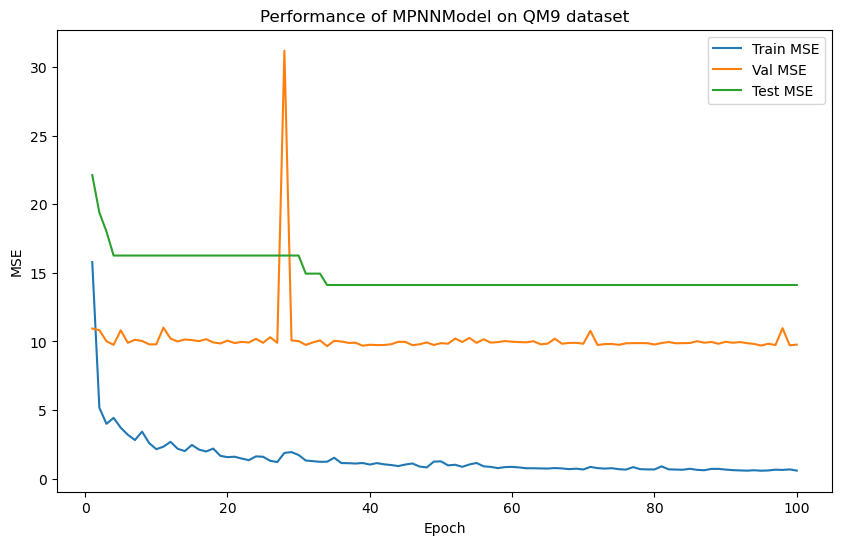

In [26]:
plt.figure(figsize=(10, 6))
plt.plot(performance_df["Epoch"], performance_df["Train MSE"], label="Train MSE")
plt.plot(performance_df["Epoch"], performance_df["Val MSE"], label="Val MSE")
plt.plot(performance_df["Epoch"], performance_df["Test MSE"], label="Test MSE")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title(f"Performance of {model_name} on QM9 dataset")
plt.legend()
#p.set(ylim=(0, 2));

Obtain predictions for test set

In [29]:
model.eval()

y_pred_list = []
y_test_list = []
y0_list = []


for data in test_loader:
    data = data.to('cpu')
    with torch.no_grad():
        y_pred = model(data)
        
        y_pred_list = y_pred_list + list(y_pred+data.y0)
        y_test_list = y_test_list + list(data.y+data.y0)
        y0_list = y0_list + list(data.y0)
        
y_pred_arr = np.array(y_pred_list)
y_test_arr = np.array(y_test_list)
y0_arr = np.array(y0_list)

Text(0.5, 1.0, 'Pre-Embedding GNN Model')

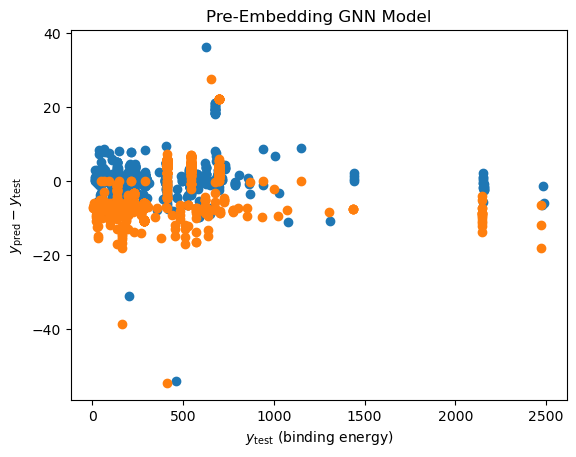

In [31]:
plt.scatter(y_test_arr, y_pred_arr-y_test_arr)
plt.scatter(y0_arr, y0_arr-y_test_arr)
plt.xlabel(r'$y_\mathrm{test}$ (binding energy)')
plt.ylabel(r'$y_\mathrm{pred}-y_\mathrm{test}$')
plt.title("Pre-Embedding GNN Model")

In [27]:
np.mean((y_pred_arr-y_test_arr))**2

4.716700299276511

In [26]:
np.mean((y_test_arr))**2

204070.53524091933